## Data Powered Postive Deviance (DPPD) Analysis

In this notebook we will show how to perform DPPD Analysis through time series decomposition. The DPPD Analysis will be based on the amount of agricultural fires that have been detected in a specific area. We have used the NASA Active Fire Dataset which detects thermal anomalies. To classify these fires into agricultrual fires and other fires, the following approach has been used https://medium.com/@shivangpandey/crop-residue-burning-in-telangana-undp-dicra-35f63aed777. The DPPD analysis can be easily done on Telangana, district, mandal, 10 km grid and, 1 km grid level (depending on what boundaries are available).

First it is important that the following packages are installed on your computer:

In [3]:
import pandas as pd
import os
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import matplotlib.pyplot as plt
import rasterio
from statsmodels.tsa.seasonal import STL
import numpy as np
from sklearn.linear_model import LinearRegression
import datetime as dt
from matplotlib.colors import TwoSlopeNorm
import time

Then we will load all different boundary files in the notebook. Here the paths need to be changed accordingly to where the boundary files have been saved.

In [4]:
#Load Data
os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Classification_Fires')
fire_data_classified = pd.read_csv('fires_data_classified.csv', index_col=0)
#Select only the agricultural fires
fire_data = fire_data_classified[fire_data_classified['agricultural'] == 1]

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\geospatial_internship\\datasets')
telangana_shape = gpd.read_file('telangana_shapefile.geojson')
telangana_shape = telangana_shape.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\src\\data_preprocessing\\tsdm\\')
district_boundaries = gpd.read_file('District_Boundary.shp')
district_boundaries = district_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\Mandal_boundaries_pre')
mandal_boundaries = gpd.read_file('mandal_boundaries.shp')
mandal_boundaries = mandal_boundaries.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\Data')
one_km_grid = gpd.read_file('telangana_1km_grid.geojson')
one_km_grid = one_km_grid.reset_index()

os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\Data')
ten_km_grid = gpd.read_file('telangana_10km_grid.geojson')
ten_km_grid = ten_km_grid.reset_index()

In order to determine the trend score of a specific area, we first subtract the seasonality of the fire line. We do this by using the, Seasonal-Trend Decomposition Procedure Based on the Loess algorithm (STL). We choose this method over the classicial approach: Moving Averages (MA), because STL can handle any type of seasonality, the user can control the rate of change of the seasonal component, it is robust to outliers, and it does not have any missing trend values unlike MA (https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693). After we have obtained the trend, we want to give it a score. A negative score will indicate a decrease in fires, a postive score will indicate an increase in fires, and a score close to zero will indicate little to no change in the amount of fires. This score is determined based on the trend line. We obtain one score for each selected are by fitting a line to the trend by using Linear Regression. The slope of this line will indicate the deviance score of that particular area.

In [5]:
def Trend_Score(df, index:int): 
    """Determines the trend score of a polygon it takes as input a dataframe that counts the fires per region per month and the index of a specific region and returns 
    the deviance score of that particular region"""
    df_selected = df[df['index'] == index] 
    df_selected = df_selected.sort_values(by=['ModifiedDateTime'])
    df_selected.index = df_selected['ModifiedDateTime']

    if not df_selected.empty:

        X = df_selected['Fires']

        #Decompose using STL Seasonal-Trend Decomposition using LOESS
        stl = STL(df_selected['Fires'], seasonal=7)
        res = stl.fit()

        df_trend = res.trend.to_frame().reset_index().dropna()

        #Date needs to be converted to a numerical value
        df_trend['ModifiedDateTime_num'] = df_trend['ModifiedDateTime'].map(dt.datetime.toordinal)

        #Set the data in the right format for Linear Regression
        X = np.array(df_trend['ModifiedDateTime_num'])
        X = X.reshape(-1, 1)
        y = np.array(df_trend['trend'])
        y = y.reshape(-1, 1)

        #Perform Linear Regression and obtain the slope
        reg = LinearRegression().fit(X, y)
        y_pred_trend = reg.predict(X)
        slope, intercept = np.polyfit(np.array(df_trend['ModifiedDateTime_num']), y_pred_trend,1)
        line_slope = slope[0]

    else:
        #If the dataframe is empty there are no fires in that region at all, also no slope line. We are not interested in these regions.
        line_slope = 'Unknown'

    return(line_slope)

In the next cell, we create a function that makes a geoplot of all slopes scores. We first do that by counting the fires per region per month and then we use the previously defined function to calculate the deviance score.

In [6]:
def fire_counts(beginyear:int, endyear:int, fire_data, boundaries, level:str):
    """Creates a visualization of all the slope scores for each region. It takes as input the begin- and endyear of interest, the fire data, the boundaries of the regions we are interested in. """
    st = time.time()

    #Create geodataframe from the data
    geo_fire_data = gpd.GeoDataFrame(fire_data,geometry = gpd.points_from_xy(fire_data.longitude,fire_data.latitude), crs = {'init': 'epsg:4326'}) 

    #Make sure the geometry columns are in the right format
    geo_fire_data = geo_fire_data[['geometry', 'acq_date', 'fireID']]
    geo_fire_data['geometry'] = geo_fire_data['geometry'].to_crs(epsg = 4326)
    boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'}) 

    #Load date into date format
    geo_fire_data['acq_date'] =  pd.to_datetime(geo_fire_data['acq_date'])
    geo_fire_data['year'] = (geo_fire_data['acq_date']).dt.year
    geo_fire_data['month'] = (geo_fire_data['acq_date']).dt.month
    geo_fire_data['day'] = (geo_fire_data['acq_date']).dt.day

    #Selects the years we are interested in, depending on the input of the function
    geo_fire_data = geo_fire_data[(geo_fire_data['acq_date'] >= str(beginyear)+'-01-01') & (geo_fire_data['acq_date'] < str(endyear+1)+'-01-01')]

    #Count all fires within a region given by the boundaries dataframe
    fires_per_boundaries= gpd.sjoin(geo_fire_data, boundaries, how="inner")

    #Create the right time format: We count per month
    fires_per_boundaries['day'] = 1 
    fires_per_boundaries['year'] = pd.Series(pd.to_numeric(fires_per_boundaries['year'], errors='coerce'), dtype='int64')
    fires_per_boundaries['month'] = pd.Series(pd.to_numeric(fires_per_boundaries['month'], errors='coerce'), dtype='int64')
    fires_per_boundaries['ModifiedDateTime'] = pd.to_datetime(fires_per_boundaries[['year', 'month', 'day']].astype('int64').astype('str'), yearfirst=True)

    #Sum amount of fires per mandal per month per year make sure that if no fire happens at a specific time write a zero
    fires_per_boundaries_count = fires_per_boundaries.groupby(['index', 'ModifiedDateTime'])['fireID'].count().unstack(fill_value=0).stack().reset_index()
    fires_per_boundaries_count['Fires'] = fires_per_boundaries_count[0] 

    #Delete column
    del fires_per_boundaries_count[0]
    
    #Make sure date is in the right format
    fires_per_boundaries_count['ModifiedDateTime'] =  pd.to_datetime(fires_per_boundaries_count['ModifiedDateTime'])

    #We will loop over all boundaries and calculate it's deviant score
    ids= []
    scores = []

    for i in range(0, len(boundaries['index'])):
        ids.append(boundaries['index'].iloc[i])
        #We use the previously defined function in order to calculate the trend score per specific area
        score = Trend_Score(fires_per_boundaries_count, i)
        scores.append(score)
    
    #Create a Dataframe from the scores
    DPPD_df = pd.DataFrame({'index': ids, 'Slope Score': scores}) 

    #Only select the regions that do not have unknown scores
    DPPD_df = DPPD_df[DPPD_df['Slope Score'] != 'Unknown']

    #We merge the dataframe with the boundaries dataframe such that we have the geometry variable
    DPPD_df = DPPD_df.merge(boundaries[['index', 'geometry']], how='left', on=['index'])

    #Making sure data has the right type
    DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
    DPPD_df['Slope Score'] = DPPD_df['Slope Score'].astype('float')

    os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\Fires\\results')
    DPPD_df.to_csv('DPPD_Fires_'+str(beginyear) +'-' + str(endyear)+ level + '.csv')
    DPPD_df = gpd.GeoDataFrame(DPPD_df, geometry = DPPD_df.geometry, crs = {'init': 'epsg:4326'}) 
    DPPD_df.to_file('C:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\Fires\\results\\DPPD_Fires_'+str(beginyear) +'-' + str(endyear)+level+'.geojson', driver="GeoJSON") 
    #Define text for the plots
    text = 'Changes in Amount of Fires over the Years STL ' + level + ' level ('+ str(beginyear) +'-'+str(endyear)+')'
   
    #Create the figure
    #If the boundary level is Telangana we need to select our own min and max legend value 
    if level == 'telangana':
        #Make sure that legend is centered around 0
        norm = TwoSlopeNorm(vmin= -0.04 , vcenter=0, vmax= 0.04) 
        cmap = 'RdYlGn_r'
        DPPD_df.plot(column = 'Slope Score', 
                            legend = True, 
                            figsize = [20,10],\
                            legend_kwds = {'label': 'Deviance'}, 
                            cmap = 'RdYlGn_r',
                            norm = norm)
        plt.title(text)
        os.chdir('c:\\Users\\Jesse\\OneDrive\\Documenten\\Master BAOR\\Thesis\\GitHub\\dicra\\analytics\\sandbox\\notebooks\\crop_fires\\DPPD_Jesse\\Fires\\results')
        plt.savefig(text + '.png', bbox_inches='tight')

    #Create the figure 
    else:
        ranges = max(abs(DPPD_df['Slope Score'].min()), (DPPD_df['Slope Score'].max()))
        vmin, vmax, vcenter = ranges*-1 , ranges, 0
        norm = TwoSlopeNorm(vmin= vmin , vcenter=vcenter, vmax= vmax) 
        # create a normalized colorbar
        cmap = 'RdYlGn_r'
        cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        DPPD_df.plot(column = 'Slope Score', 
                            legend = True, 
                            figsize = [20,10],\
                            legend_kwds = {'label': 'Deviance'}, 
                            cmap = 'RdYlGn_r',
                            norm = norm)
        plt.title(text)
        plt.savefig(text + '.png', bbox_inches='tight')
    
    #Print the time it took to run this is no more than 15 min no matter the boundary type
    print('Scores are calculated in',  str((time.time()-st)/60) , ' minutes')
    
    return(plt.show(), DPPD_df)


We can now call our function with the parameters we are interested in. For the fire data we only have it available for the years 2015-2021 and for the boundaries we can do the analysis on telangana, district, mandal, 10 km or 1 km level.

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.08935854037602743  minutes


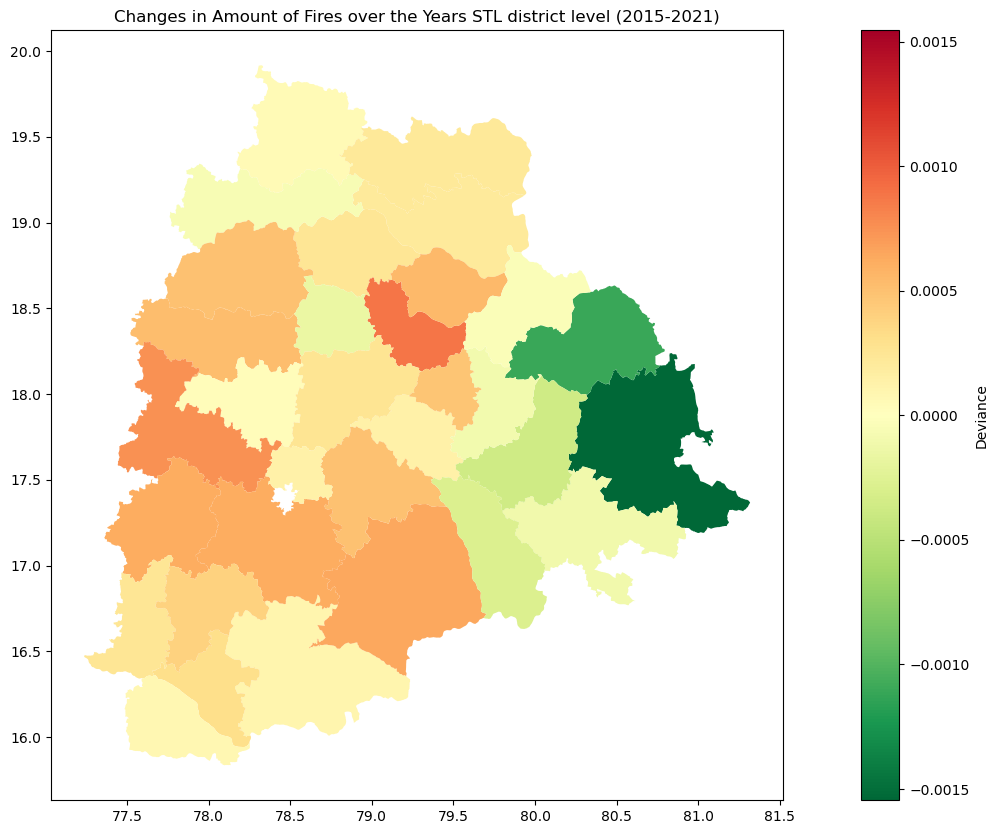

In [7]:
figure, DPPD_df_district_2021 = fire_counts(2015, 2021, fire_data, district_boundaries, 'district')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.3066089709599813  minutes


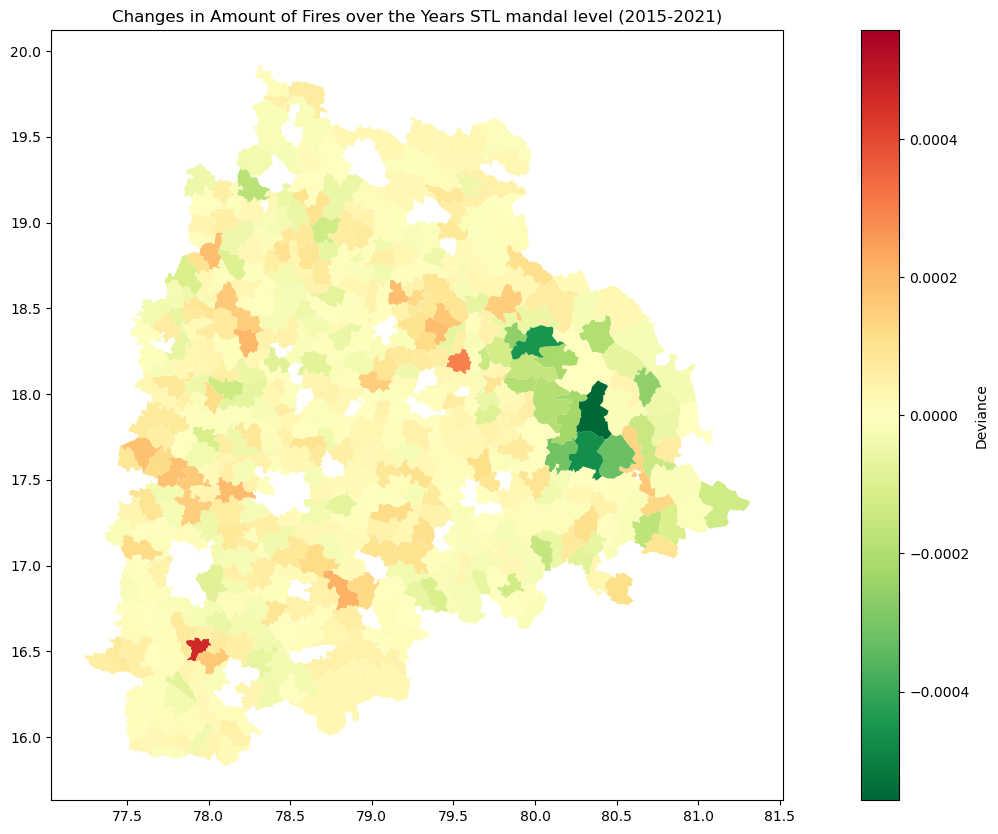

In [8]:
figure, DPPD_df_mandal_2021 = fire_counts(2015, 2021, fire_data, mandal_boundaries, 'mandal')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.6223424077033997  minutes


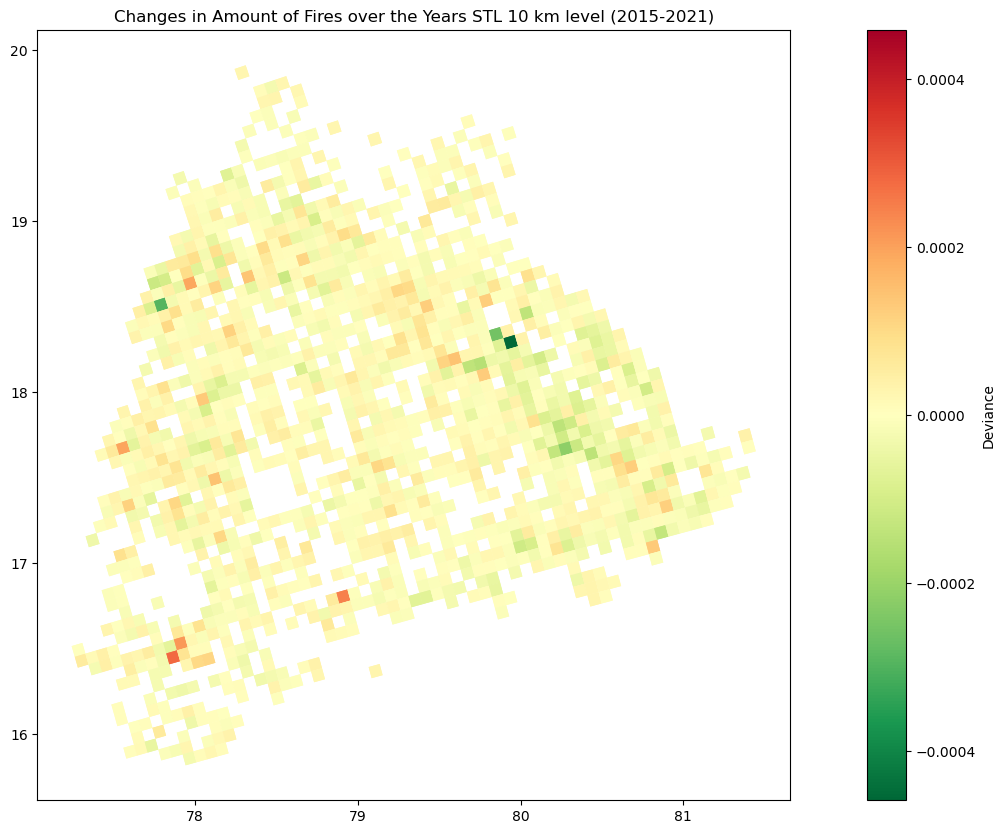

In [9]:
figure, DPPD_df_ten_km_2020 = fire_counts(2015, 2021, fire_data, ten_km_grid, '10 km')

In [ ]:
figure, DPPD_df_1km_2021 = fire_counts(2015, 2021, fire_data, one_km_grid, '1 km')

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.08177378177642822  minutes


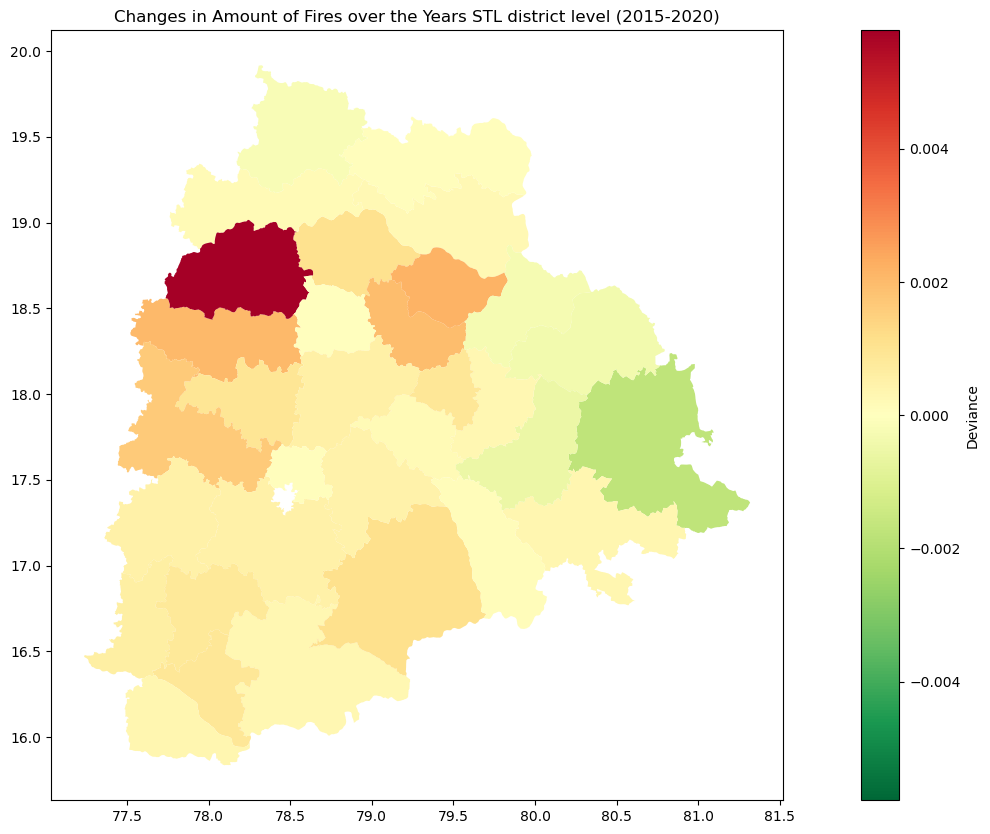

In [11]:
figure, DPPD_df_mandal_2020 = fire_counts(2015, 2020, fire_data, district_boundaries, 'district')

# Check Impact COVID Years on Deviance Scores

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.2374785264333089  minutes


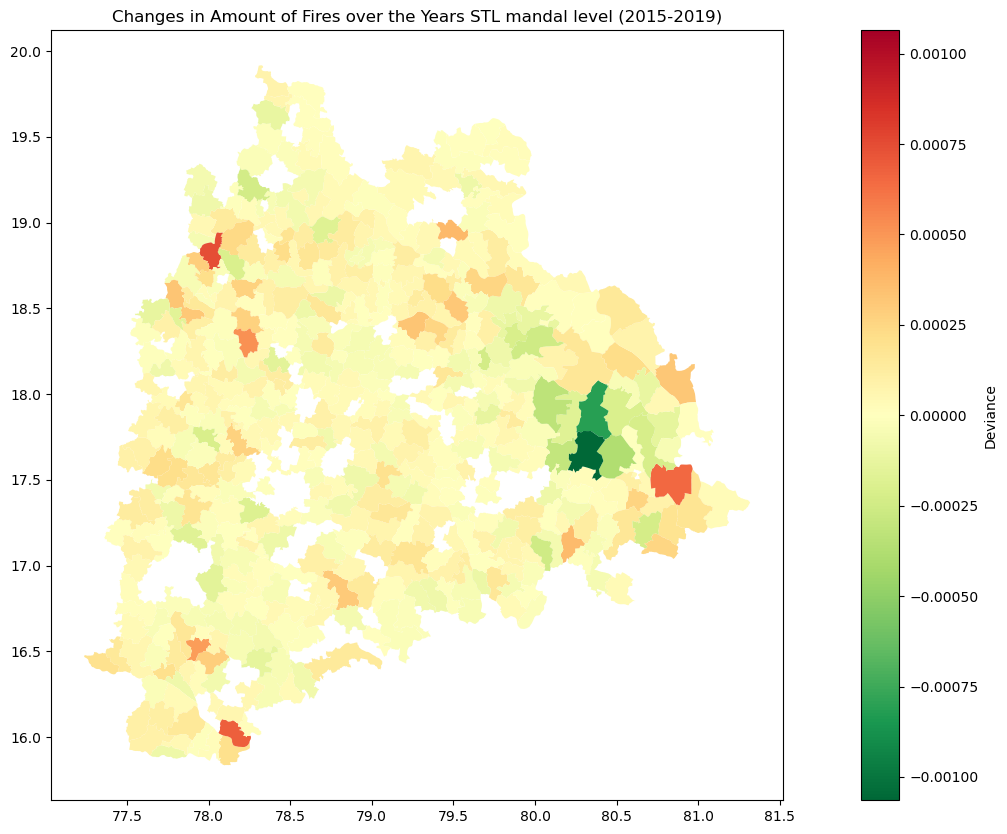

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.31307919025421144  minutes


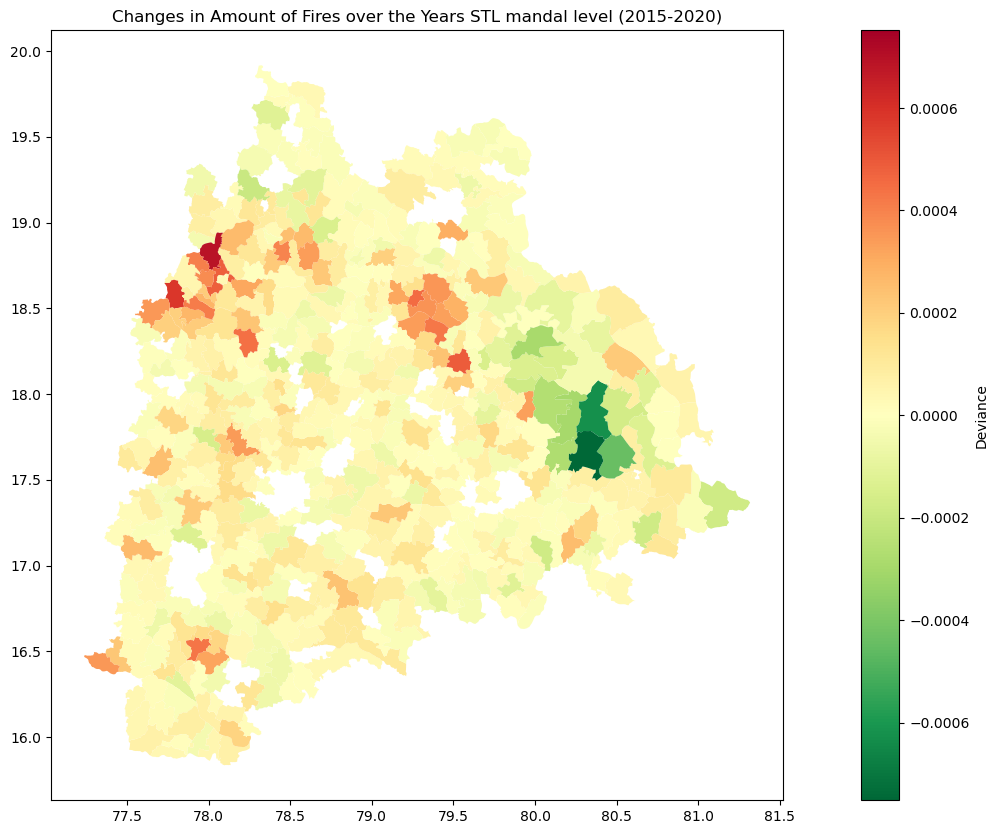

c:\Users\Jesse\Anaconda3\envs\gurobi\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
<ipython-input-6-4e6a266424a1>:11: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  boundaries = gpd.GeoDataFrame(boundaries,geometry = boundaries.geometry, crs = {'init': 'epsg:4326'})
<ipython-input-6-4e6a266424a1>:23: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CR

Scores are calculated in 0.3359955668449402  minutes


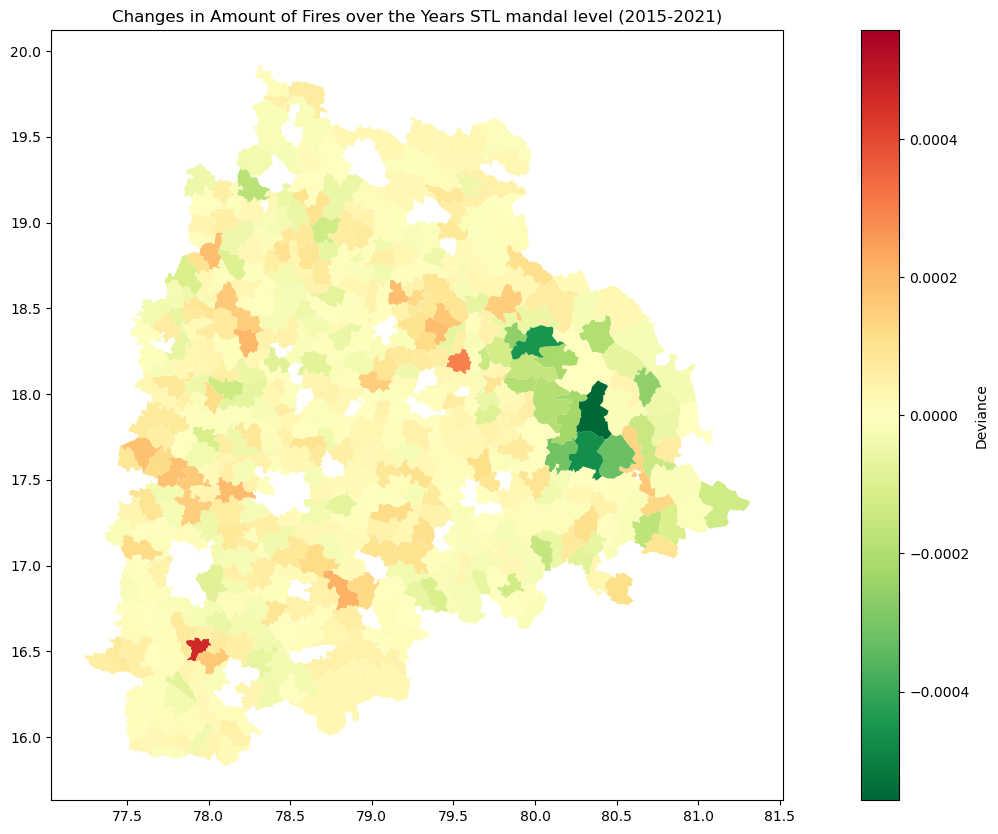

In [10]:
figure, DPPD_df_mandal_2019 = fire_counts(2015, 2019, fire_data, mandal_boundaries, 'mandal')
figure, DPPD_df_mandal_2020 = fire_counts(2015, 2020, fire_data, mandal_boundaries, 'mandal')
figure, DPPD_df_mandal_2021 = fire_counts(2015, 2021, fire_data, mandal_boundaries, 'mandal')

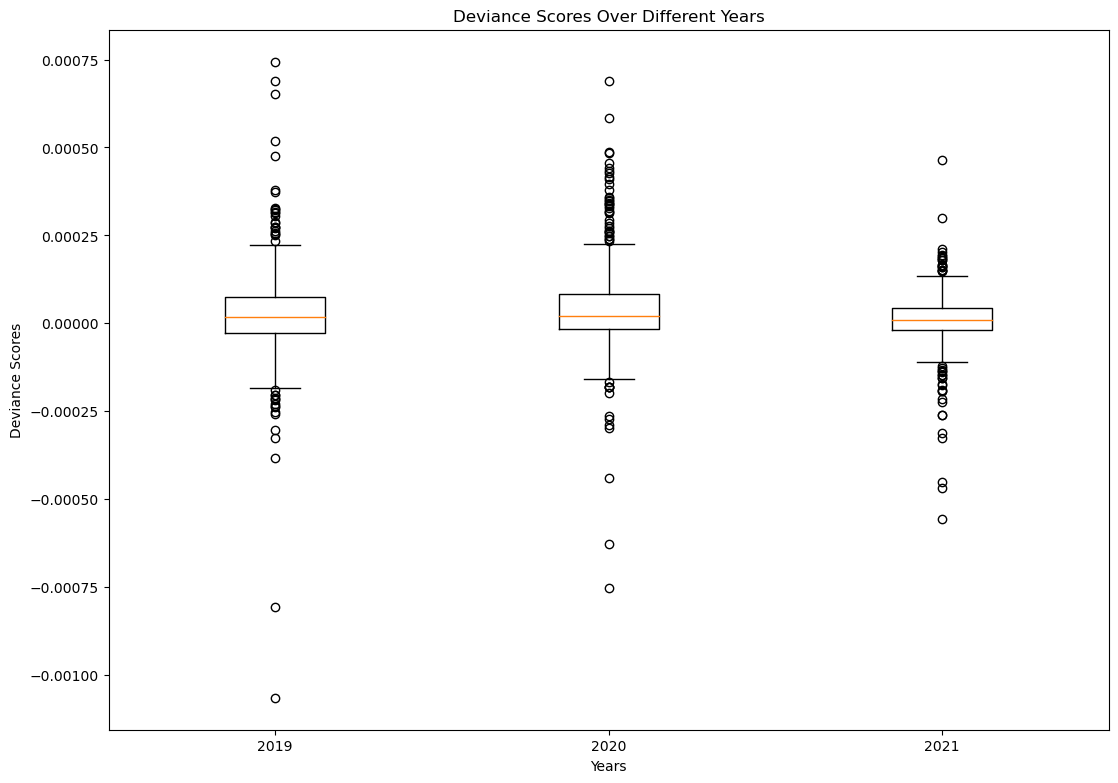

In [82]:
data = [DPPD_df_mandal_2019['Slope Score'], DPPD_df_mandal_2020['Slope Score'], DPPD_df_mandal_2021['Slope Score']]
 
fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data)
 
plt.title('Deviance Scores Over Different Years')

ax.set_xticklabels(['2019', '2020', '2021'])

plt.ylabel('Deviance Scores')
plt.xlabel('Years')
# show plot
plt.savefig('Deviance Scores Differences.png')
plt.show()


